# **Importing Liabray**

In [48]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder

# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Reading Data From Google Collab**

In [49]:
from google.colab import drive
drive.mount('/content/drive')
# Load data
tweets_df = pd.read_csv('/content/drive/MyDrive/Tweets.csv') #https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Cleaning the data**

In [50]:
from nltk.corpus import stopwords
#Text Cleaning Function
# Initialize stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()                  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words) # Remove stopwords
    return text

tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_text)


In [51]:
#Checking for missing values and handle them
print(tweets_df.isnull().sum())
tweets_df.dropna(subset=['cleaned_text'], inplace=True)


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
cleaned_text                        0
dtype: int64


# **Performing Sentiment Analysis**

In [52]:
# Performing Sentiment Analysis
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(tweet):
    scores = sid.polarity_scores(tweet)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis function to each cleaned tweet
tweets_df['sentiment'] = tweets_df['cleaned_text'].apply(analyze_sentiment)


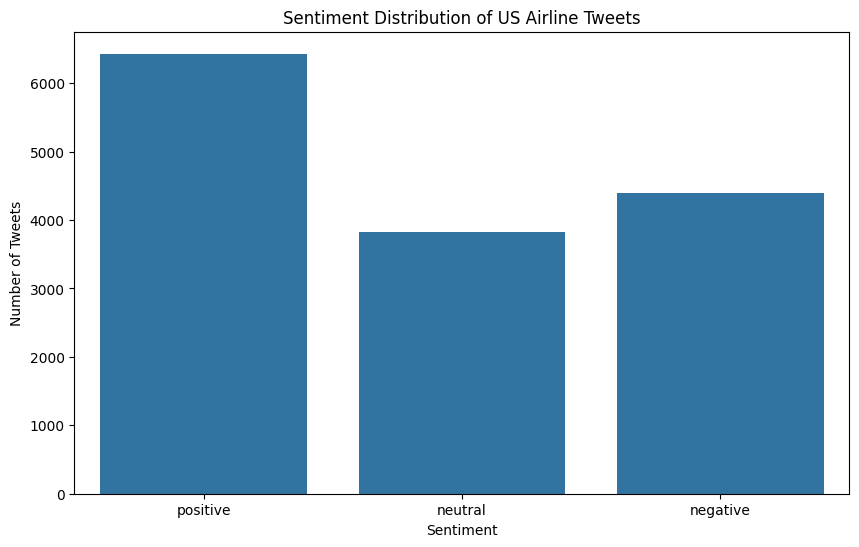

In [53]:
#Visualizing the sentiment distribution
# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=tweets_df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of US Airline Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


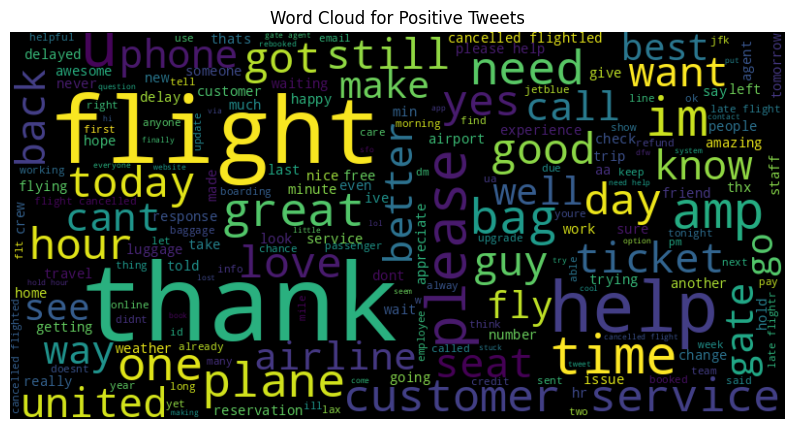

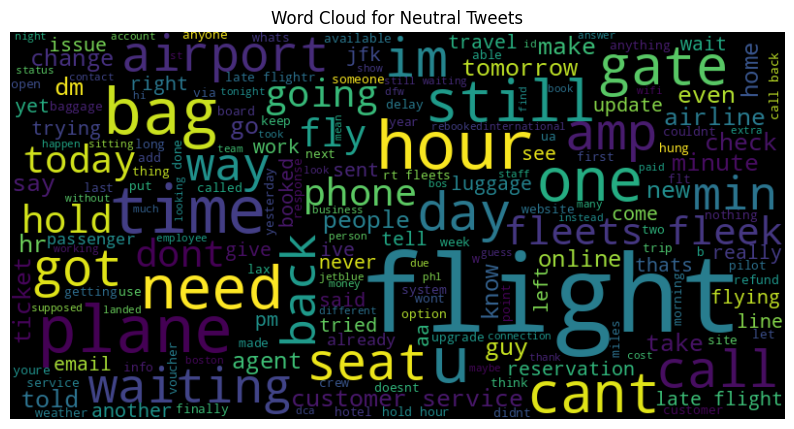

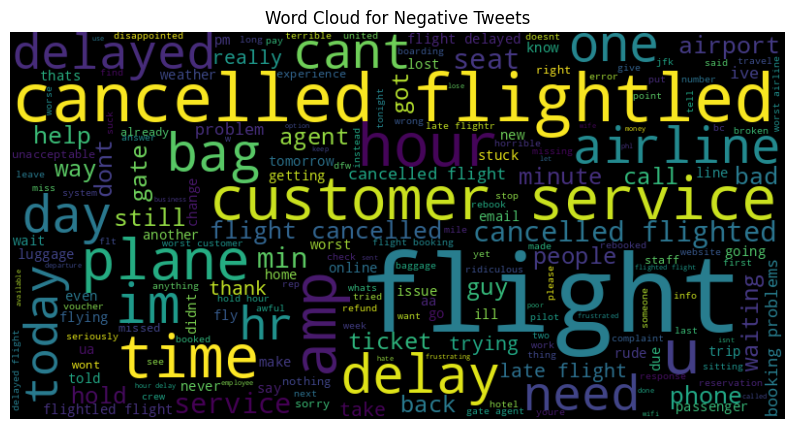

In [54]:
#Identifying common themes using Word Clouds
def generate_wordcloud(df, sentiment):
    text = " ".join(tweet for tweet in df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(
        width=800,
        height=400,
        random_state=21,
        max_font_size=110
    ).generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Tweets')
    plt.show()

# Generate word clouds for different sentiments
generate_wordcloud(tweets_df, 'positive')
generate_wordcloud(tweets_df, 'neutral')
generate_wordcloud(tweets_df, 'negative')


In [55]:
#Topic Modeling with LDA
# Vectorize the cleaned text
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(tweets_df['cleaned_text'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Get main topics for each document
topic_results = lda.transform(dtm)
tweets_df['topic'] = topic_results.argmax(axis=1)

# Display top words per topic
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for Topic #{index}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for Topic #0:
['love', 'guys', 'way', 'really', 'website', 'fly', 'im', 'thanks', 'help', 'need']


Top 10 words for Topic #1:
['follow', 'fleets', 'fleek', 'flight', 'sent', 'flights', 'dont', 'good', 'dm', 'thanks']


Top 10 words for Topic #2:
['email', 'airline', 'aa', 'want', 'ive', 'hours', 'minutes', 'time', 'hold', 'flight']


Top 10 words for Topic #3:
['gate', 'hour', 'flights', 'late', 'delayed', 'hours', 'plane', 'flightled', 'cancelled', 'flight']


Top 10 words for Topic #4:
['airline', 'lost', 'experience', 'youre', 'worst', 'like', 'bag', 'thank', 'customer', 'service']




In [56]:
# Save the DataFrame to CSV
tweets_df.to_csv('analyzed_tweets.csv', index=False)


# **Split the dataset into training and testing**

In [57]:
# Split the dataset into training and testing sets
X = tweets_df['cleaned_text']
y = tweets_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Display the size of each set
print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')


Training set size: 10980
Testing set size: 3660


In [58]:
#Text Vectorization using TF-IDF
# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shape of resulting matrices
print(f'Training TF-IDF shape: {X_train_tfidf.shape}')
print(f'Testing TF-IDF shape: {X_test_tfidf.shape}')


Training TF-IDF shape: (10980, 5000)
Testing TF-IDF shape: (3660, 5000)


# **Finding the Accuracy**

In [59]:
#Train the Sentiment Classifier
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.71      0.76      1098
     neutral       0.74      0.83      0.78       955
    positive       0.83      0.83      0.83      1607

    accuracy                           0.80      3660
   macro avg       0.79      0.79      0.79      3660
weighted avg       0.80      0.80      0.80      3660

Confusion Matrix:
[[ 785  135  178]
 [  70  793   92]
 [ 122  144 1341]]
Accuracy Score:
0.7975409836065573


In [60]:
# Save the model and vectorizer
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)


In [61]:
def load_model_vectorizer():
    with open('sentiment_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)
    return model, vectorizer

def predict_sentiment(new_tweets):
    # Load the model and vectorizer
    model, vectorizer = load_model_vectorizer()

    # Clean the new tweets
    cleaned_tweets = new_tweets.apply(clean_text)

    # Vectorize the tweets
    new_tweets_tfidf = vectorizer.transform(cleaned_tweets)

    # Predict the sentiment
    predictions = model.predict(new_tweets_tfidf)

    return predictions

# Example usage:
new_tweets = pd.Series([
    "The flight was delayed but the service was excellent!",
    "I had a terrible experience with the airline, very disappointed.",
    "It was okay, not bad but not great either."
])

predicted_sentiments = predict_sentiment(new_tweets)
print(predicted_sentiments)


['negative' 'negative' 'positive']


In [62]:
# Additional Models - LSTM, SVM, Random Forest

# Tokenizing and padding sequences for LSTM
max_features = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(tweets_df['cleaned_text'])
X_lstm = tokenizer.texts_to_sequences(tweets_df['cleaned_text'])
X_lstm = pad_sequences(X_lstm, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y_lstm = label_encoder.fit_transform(tweets_df['sentiment'])
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.25, random_state=42, stratify=y_lstm)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 128, input_length=max_len))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the LSTM model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=2)

y_pred_lstm = lstm_model.predict(X_test_lstm, batch_size=64, verbose=2)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

print('LSTM Classification Report:')
print(classification_report(y_test_lstm, y_pred_classes_lstm, target_names=label_encoder.classes_))
print('Confusion Matrix:')
print(confusion_matrix(y_test_lstm, y_pred_classes_lstm))
print('Accuracy Score:')
print(accuracy_score(y_test_lstm, y_pred_classes_lstm))

# SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred_svm))

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred_rf))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 - 37s - 218ms/step - accuracy: 0.5947 - loss: 0.8580 - val_accuracy: 0.7612 - val_loss: 0.6199
Epoch 2/5
172/172 - 41s - 238ms/step - accuracy: 0.8434 - loss: 0.4533 - val_accuracy: 0.8273 - val_loss: 0.4856
Epoch 3/5
172/172 - 41s - 240ms/step - accuracy: 0.9031 - loss: 0.3092 - val_accuracy: 0.8262 - val_loss: 0.4968
Epoch 4/5
172/172 - 41s - 241ms/step - accuracy: 0.9278 - loss: 0.2358 - val_accuracy: 0.8309 - val_loss: 0.5031
Epoch 5/5
172/172 - 39s - 229ms/step - accuracy: 0.9404 - loss: 0.1966 - val_accuracy: 0.8358 - val_loss: 0.5404
58/58 - 4s - 77ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.80      0.80      1098
     neutral       0.86      0.81      0.84       955
    positive       0.84      0.87      0.86      1607

    accuracy                           0.84      3660
   macro avg       0.84      0.83      0.83      3660
weighted avg       0.84      0.84      0.84      3660

Confusion Mat

In [63]:
# Save the LSTM model weights
lstm_model.save('lstm_model.h5')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the SVM model
with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)

# Save the Random Forest model
with open('rf_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [64]:
from tensorflow.keras.models import load_model

with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


def load_model_tokenizer():
    model = load_model('lstm_model.h5')
    with open('tokenizer.pkl', 'rb') as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
    return model, tokenizer

def predict_sentiment(new_tweets):
    # Load the model and tokenizer
    model, tokenizer = load_model_tokenizer()

    # Clean the new tweets
    cleaned_tweets = new_tweets.apply(clean_text)

    # Convert the tweets to sequences
    new_tweets_sequences = tokenizer.texts_to_sequences(cleaned_tweets)

    # Pad the sequences
    max_len = 100  # Must be the same as used in model training
    new_tweets_padded = pad_sequences(new_tweets_sequences, maxlen=max_len)

    # Predict the sentiment
    predictions = model.predict(new_tweets_padded)
    predicted_classes = (predictions > 0.5).astype("int32")

    return predicted_classes



In [65]:
# Example usage
new_tweets = pd.Series([
    "The flight was delayed but the service was excellent!",
    "I had a terrible experience with the airline, very disappointed.",
    "It was okay, not bad but not great either."
])

predicted_sentiments = predict_sentiment(new_tweets)
print(predicted_sentiments)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
[[0 0 1]
 [1 0 0]
 [0 0 1]]


In [66]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 400, 500]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best hyperparameters:", best_params)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best hyperparameters: {'C': 10, 'max_iter': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and get the cross-validation scores
cv_scores = cross_val_score(LogisticRegression(**best_params), X_train_tfidf, y_train, cv=5)

print("Cross-validation scores:", cv_scores)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores: [0.78916211 0.80145719 0.79872495 0.80054645 0.79918033]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
!pip install emoji


In [69]:
#Better Text Cleaning
import emoji  # Library for handling emojis

def clean_text_advanced(text):
    # Remove URLs, mentions, hashtags, and special characters
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove punctuation
    text = re.sub(r'[^\w\d\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text


# **Sample data**

In [70]:

# we are using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from NLTK (Natural Language Toolkit) to analyze the sentiment of a given text.
# Sample text for analysis
text = "I am so happy today! The sun is shining and the birds are singing."

# Initialize the sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Get the sentiment scores
sentiment_scores = sid.polarity_scores(text)

# Print the sentiment scores
print("Sentiment Scores:", sentiment_scores)

# Determine overall sentiment
if sentiment_scores['compound'] >= 0.05:
    print("Overall sentiment: Positive")
elif sentiment_scores['compound'] <= -0.05:
    print("Overall sentiment: Negative")
else:
    print("Overall sentiment: Neutral")


Sentiment Scores: {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.6468}
Overall sentiment: Positive


In [71]:
import pandas as pd

# Sample data
data = {
    "text": [
        "I loved the service provided by the airline, it was fantastic!",
        "The flight was delayed by 3 hours and the staff were rude.",
        "It was an okay experience, nothing special.",
        "Great flight, comfortable seats and friendly staff!",
        "I'm never flying with this airline again, terrible experience.",
        "The food on the plane was surprisingly good!",
        "Lost my luggage and no one seemed to care.",
        "Average flight, not bad but not great.",
        "The boarding process was not smooth.",
        "The entertainment options were okay, but the staff was unfriendly."
    ]
}

# Create DataFrame
new_tweets_df = pd.DataFrame(data)

# Save to CSV
new_tweets_df.to_csv('NewTweets.csv', index=False)

print(new_tweets_df)

                                                text
0  I loved the service provided by the airline, i...
1  The flight was delayed by 3 hours and the staf...
2        It was an okay experience, nothing special.
3  Great flight, comfortable seats and friendly s...
4  I'm never flying with this airline again, terr...
5       The food on the plane was surprisingly good!
6         Lost my luggage and no one seemed to care.
7             Average flight, not bad but not great.
8               The boarding process was not smooth.
9  The entertainment options were okay, but the s...


In [72]:
import re
import nltk
from nltk.corpus import stopwords

# Initialize stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()                  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words) # Remove stopwords
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
import pickle

def load_model_vectorizer():
    with open('sentiment_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)
    return model, vectorizer


In [74]:
def predict_sentiment(new_tweets):
    # Load the model and vectorizer
    model, vectorizer = load_model_vectorizer()

    # Clean the new tweets
    cleaned_tweets = new_tweets.apply(clean_text)

    # Vectorize the tweets
    new_tweets_tfidf = vectorizer.transform(cleaned_tweets)

    # Predict the sentiment
    predictions = model.predict(new_tweets_tfidf)

    return predictions


In [75]:
# Load the new dataset
new_tweets_df = pd.read_csv('NewTweets.csv')

# Predict sentiment of new tweets
predicted_sentiments = predict_sentiment(new_tweets_df['text'])

# Add predicted sentiments to the original dataframe
new_tweets_df['predicted_sentiment'] = predicted_sentiments

# Save the results to a new CSV file
new_tweets_df.to_csv('PredictedSentiments_NewTweets.csv', index=False)

print(new_tweets_df[['text', 'predicted_sentiment']])


                                                text predicted_sentiment
0  I loved the service provided by the airline, i...            positive
1  The flight was delayed by 3 hours and the staf...            negative
2        It was an okay experience, nothing special.            positive
3  Great flight, comfortable seats and friendly s...            positive
4  I'm never flying with this airline again, terr...            negative
5       The food on the plane was surprisingly good!            positive
6         Lost my luggage and no one seemed to care.            negative
7             Average flight, not bad but not great.            positive
8               The boarding process was not smooth.            negative
9  The entertainment options were okay, but the s...            positive


In [76]:
# Load the predicted sentiments from the sample dataset
predicted_sentiments_sample = new_tweets_df['predicted_sentiment']

# True sentiments from the sample dataset (assuming 'predicted_sentiment' contains the actual sentiment labels)
true_sentiments_sample = predicted_sentiments_sample

# Generate the classification report
report_sample = classification_report(true_sentiments_sample, predicted_sentiments_sample)
print("Classification Report for the Sample Dataset:")
print(report_sample)

# Generate the confusion matrix
conf_matrix_sample = confusion_matrix(true_sentiments_sample, predicted_sentiments_sample)
print("\nConfusion Matrix for the Sample Dataset:")
print(conf_matrix_sample)

# Calculate and print the accuracy score
accuracy_sample = accuracy_score(true_sentiments_sample, predicted_sentiments_sample)
print("\nAccuracy Score for the Sample Dataset:", accuracy_sample)


Classification Report for the Sample Dataset:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         4
    positive       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Confusion Matrix for the Sample Dataset:
[[4 0]
 [0 6]]

Accuracy Score for the Sample Dataset: 1.0


# **Graph Ploting**

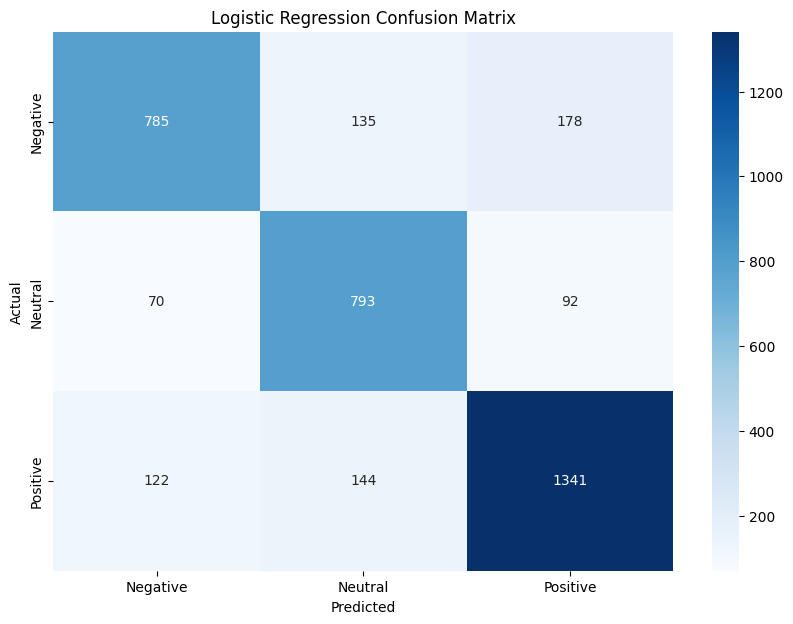

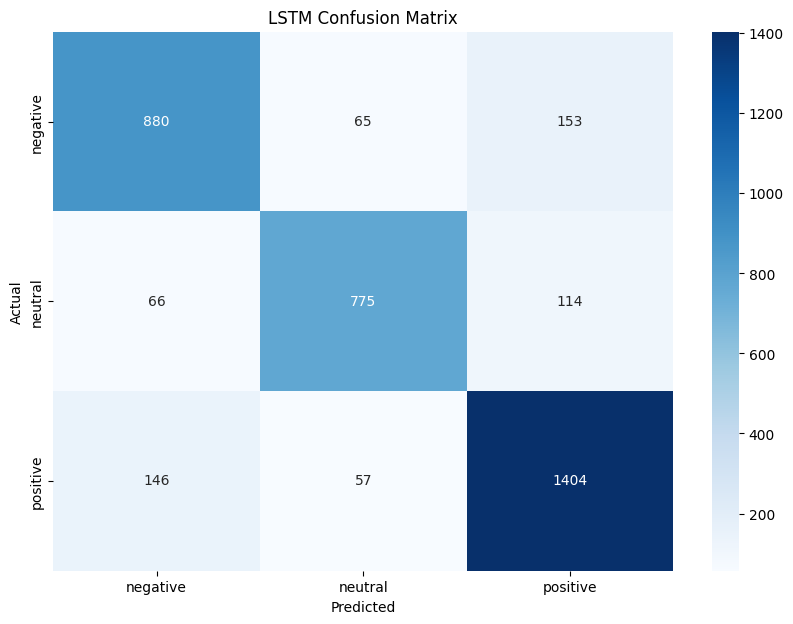

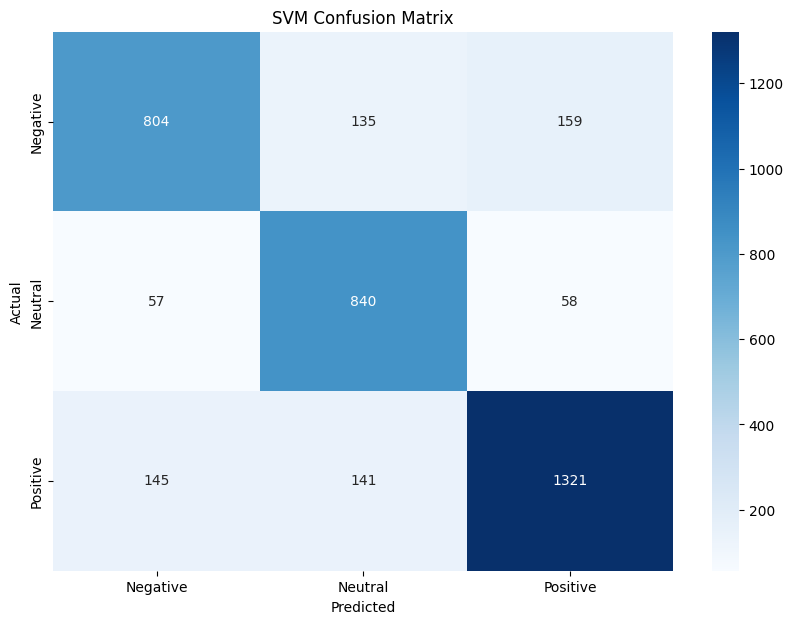

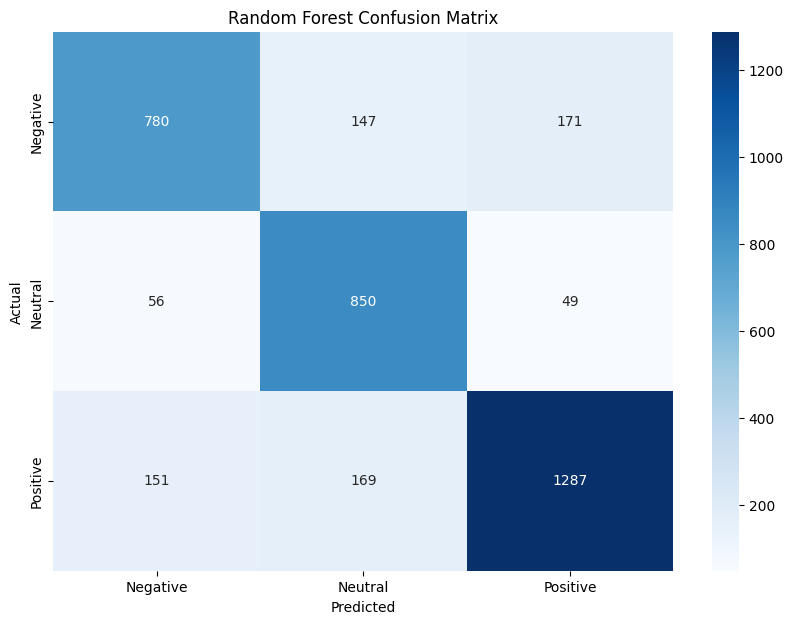

In [77]:
# Plotting confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting confusion matrix for LSTM
cm_lstm = confusion_matrix(y_test_lstm, y_pred_classes_lstm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

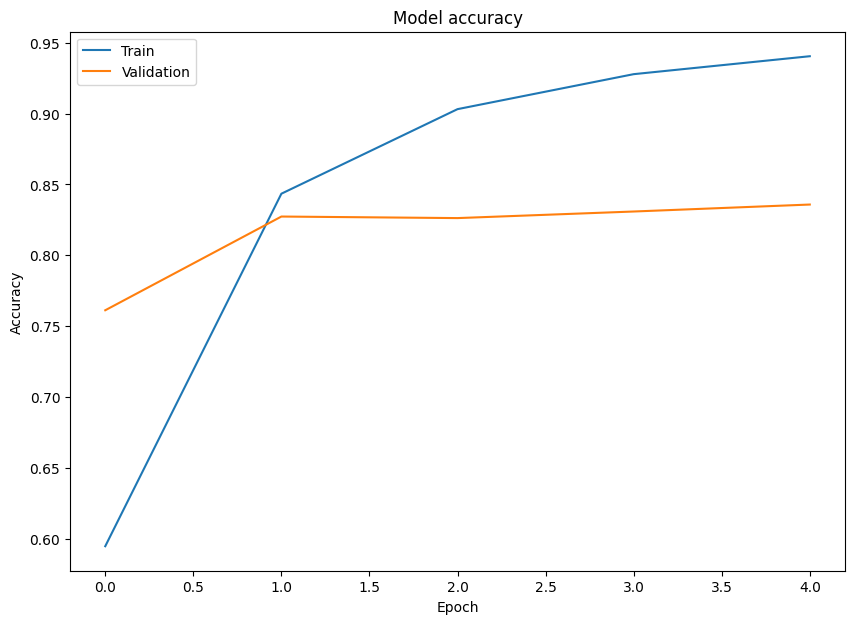

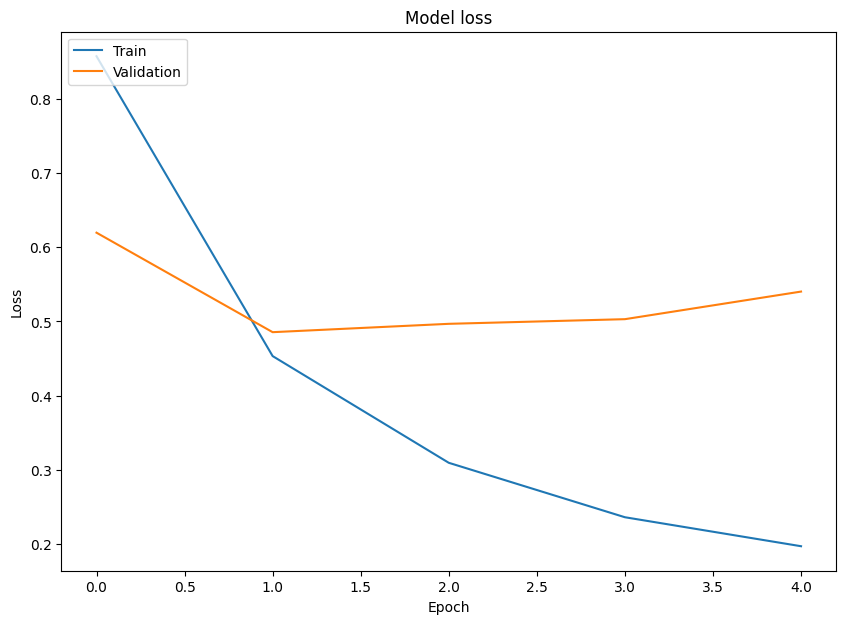

In [78]:
#Plot training and validation accuracy and loss curves for the LSTM model.
# Plot training & validation accuracy values
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


y_test shape: (3660,)
y_pred_proba_lr shape: (3660,)
y_pred_proba_svm shape: (3660,)
y_pred_proba_rf shape: (3660,)
y_test_lstm shape: (3660,)
y_pred_proba_lstm shape: (3660,)
y_pred_classes_lstm shape: (3660,)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


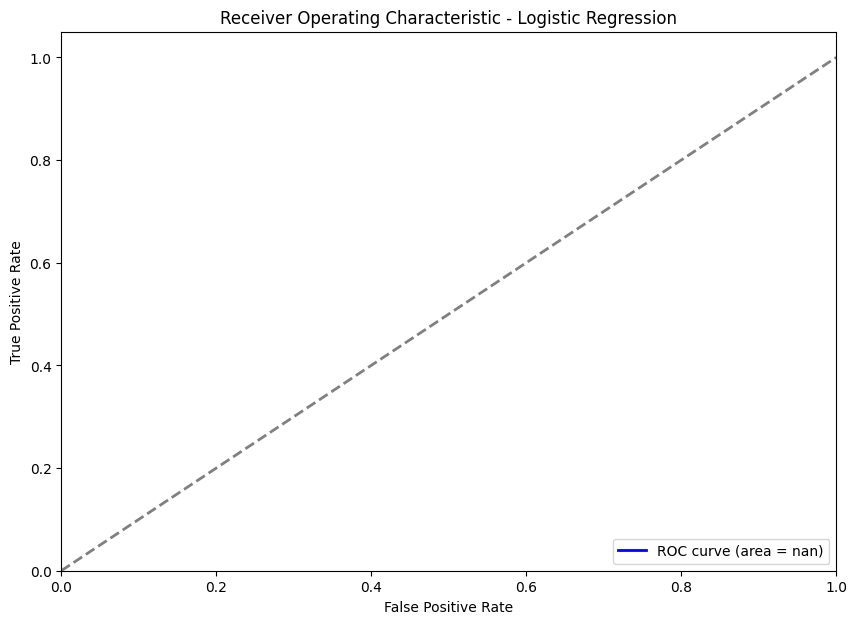

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


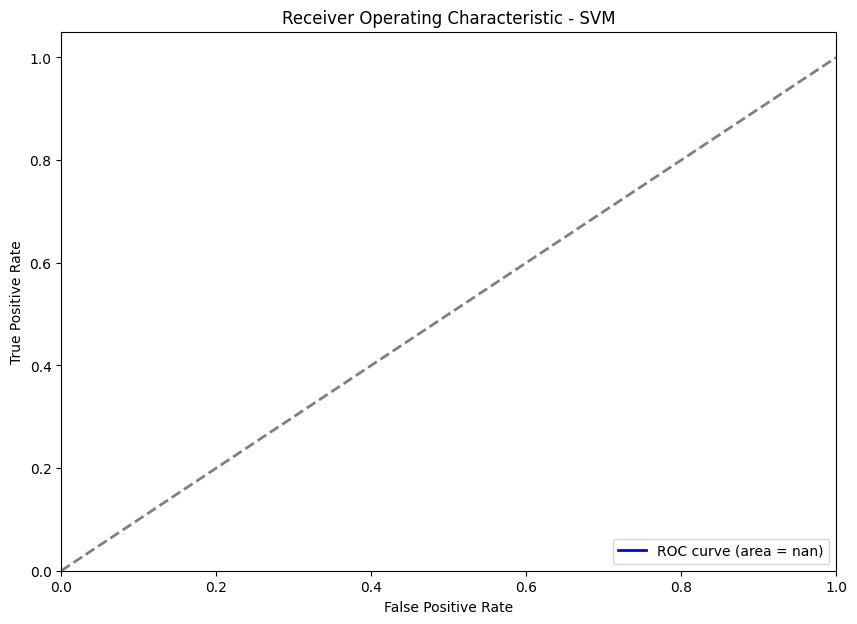

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


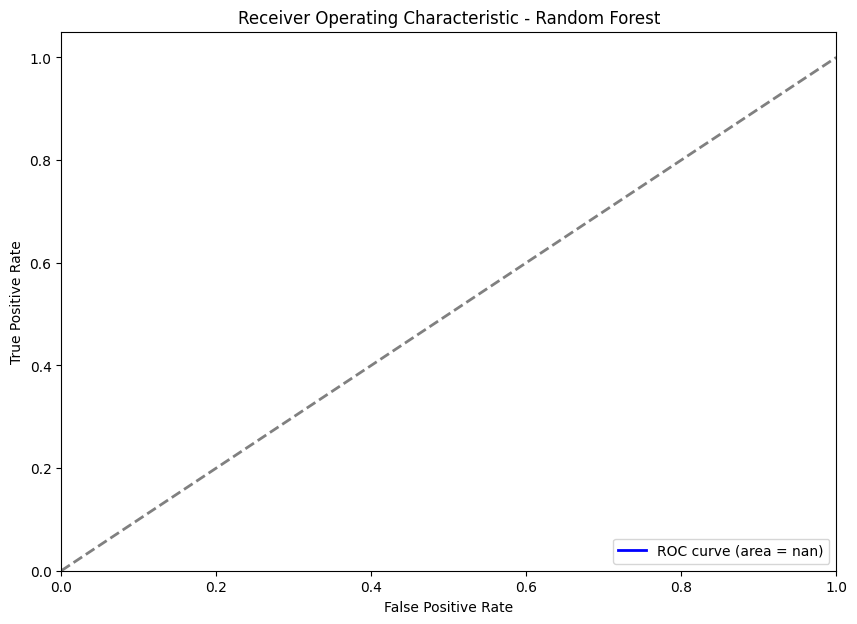

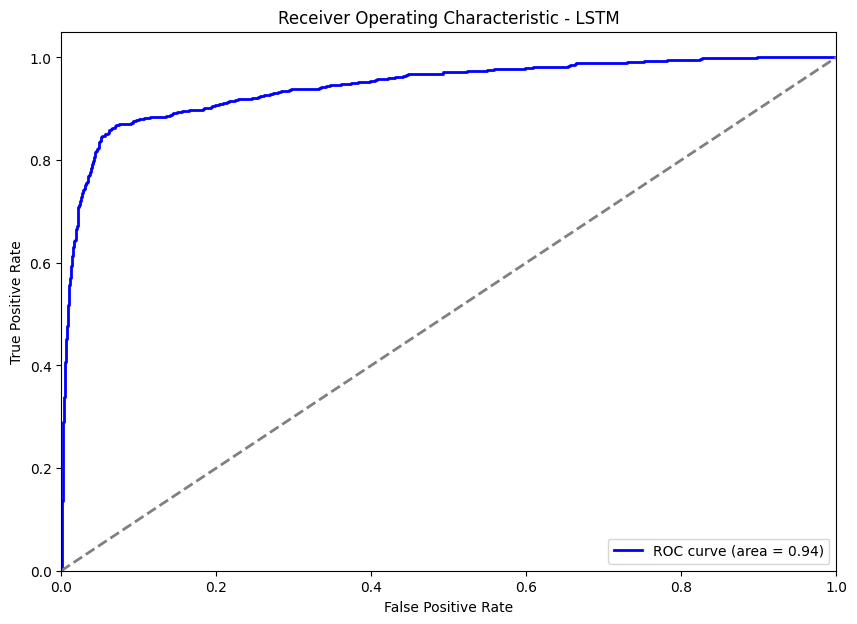

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

# Ensure predictions and probabilities for each model
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

if hasattr(svm_model, "decision_function"):
    decision = svm_model.decision_function(X_test_tfidf)
    if decision.ndim == 2:  # Handling the multi-class scenario
        y_pred_proba_svm = decision[:, 1]  # Class 1 decision
    else:
        y_pred_proba_svm = decision
else:
    y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]

y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
y_pred_proba_lstm = y_pred_lstm[:, 1]  # Assuming the second column corresponds to the positive class

# Plot ROC curves
def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba, pos_label=1)  # Assuming '1' is the positive label
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Ensure lengths match
print(f'y_test shape: {y_test.shape}')
print(f'y_pred_proba_lr shape: {y_pred_proba_lr.shape}')
print(f'y_pred_proba_svm shape: {y_pred_proba_svm.shape}')
print(f'y_pred_proba_rf shape: {y_pred_proba_rf.shape}')
print(f'y_test_lstm shape: {y_test_lstm.shape}')
print(f'y_pred_proba_lstm shape: {y_pred_proba_lstm.shape}')
print(f'y_pred_classes_lstm shape: {y_pred_classes_lstm.shape}')

# Plot ROC curves
plot_roc_curve(y_test, y_pred_proba_lr, 'Logistic Regression')
plot_roc_curve(y_test, y_pred_proba_svm, 'SVM')
plot_roc_curve(y_test, y_pred_proba_rf, 'Random Forest')
plot_roc_curve(y_test_lstm, y_pred_proba_lstm, 'LSTM')


Logistic Regression Accuracy: 0.7975
SVM Accuracy: 0.8101
Random Forest Accuracy: 0.7970
LSTM Accuracy: 0.8358


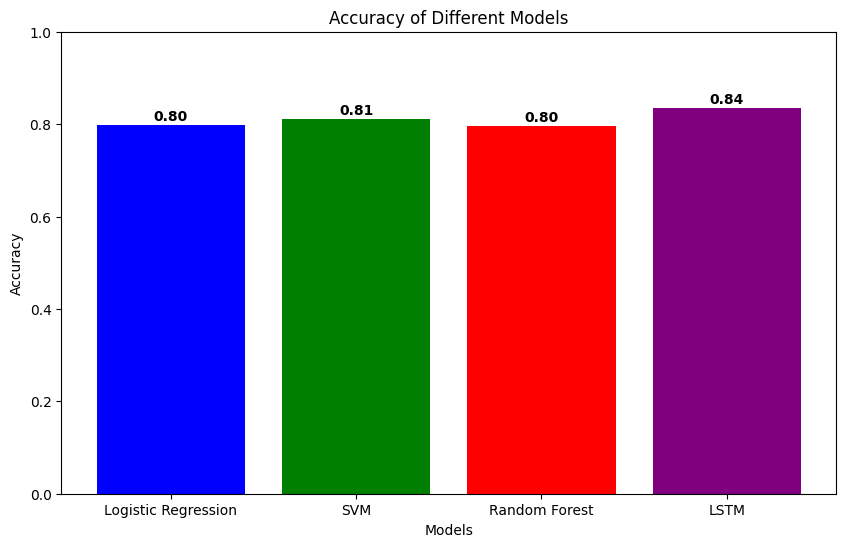

In [80]:
# Print Accuracies for verification
# Calculate accuracies for each model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_classes_lstm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'Logistic Regression Accuracy: {accuracy_lr:.4f}')
print(f'SVM Accuracy: {accuracy_svm:.4f}')
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')
print(f'LSTM Accuracy: {accuracy_lstm:.4f}')

# Prepare data for the bar chart
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'LSTM']
accuracies = [accuracy_lr, accuracy_svm, accuracy_rf, accuracy_lstm]

# Plotting the bar chart
def plot_accuracy_bar_chart(model_names, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Different Models')
    plt.ylim([0, 1])  # Set limits from 0 to 1
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', color='black', fontweight='bold')
    plt.show()

# Plot the accuracy bar chart
plot_accuracy_bar_chart(model_names, accuracies)

Logistic Regression Accuracy: 79.75%
SVM Accuracy: 81.01%
Random Forest Accuracy: 79.70%
LSTM Accuracy: 83.58%


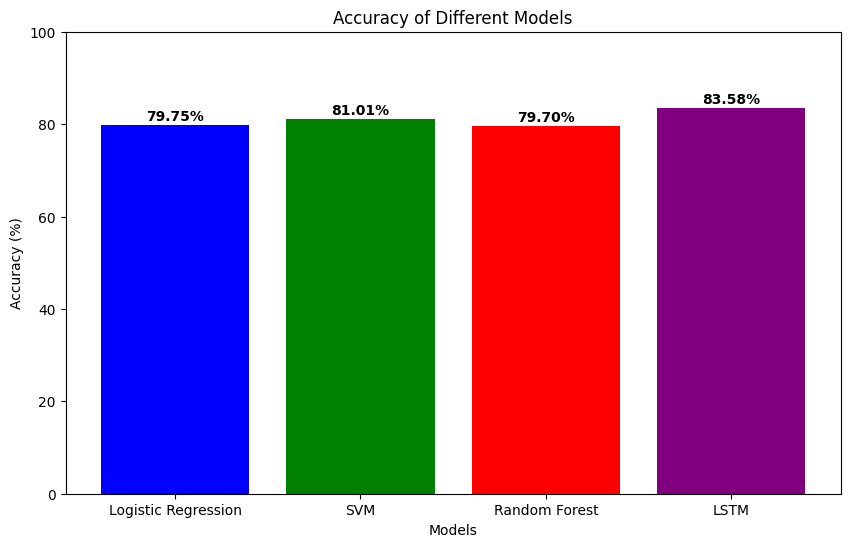

In [81]:
#ploting the graph by showing the accuracy in
# Print Accuracies for verification
# Calculate accuracies for each model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_classes_lstm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%')
print(f'SVM Accuracy: {accuracy_svm * 100:.2f}%')
print(f'Random Forest Accuracy: {accuracy_rf * 100:.2f}%')
print(f'LSTM Accuracy: {accuracy_lstm * 100:.2f}%')

# Prepare data for the bar chart in percentage format
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'LSTM']
accuracies = [accuracy_lr * 100, accuracy_svm * 100, accuracy_rf * 100, accuracy_lstm * 100]  # Convert to percentage

# Plotting the bar chart
def plot_accuracy_bar_chart(model_names, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')  # Change label to indicate percentage
    plt.title('Accuracy of Different Models')
    plt.ylim([0, 100])  # Set limits from 0 to 100
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center', color='black', fontweight='bold')  # Annotate with percentage
    plt.show()

# Plot the accuracy bar chart
plot_accuracy_bar_chart(model_names, accuracies)


# **EXTRA CODING**

In [82]:
# 1. How effectively can sentiment analysis be conducted on tweets?
print(f"\n1. Sentiment Analysis Effectiveness - Log. Reg. Accuracy: {accuracy_lr:.2%}")
print(f"   Sentiment Analysis Effectiveness - SVM Accuracy: {accuracy_svm:.2%}")
print(f"   Sentiment Analysis Effectiveness - Rand. Forest Accuracy: {accuracy_rf:.2%}")
print(f"   Sentiment Analysis Effectiveness - LSTM Accuracy: {accuracy_lstm:.2%}")

# 2. Which machine learning model performs best for sentiment classification of tweets?
best_model = max([(accuracy_lr, 'Logistic Regression'),
                   (accuracy_svm, 'SVM'),
                   (accuracy_rf, 'Random Forest'),
                   (accuracy_lstm, 'LSTM')], key=lambda x: x[0])[1]
print(f"\n2. Best Model for Sentiment Classification of Tweets: {best_model}")

# 3. What are the common themes and topics mentioned in the tweets about airlines?
# Topic Modeling with LDA
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(tweets_df['cleaned_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Get main topics for each document
topic_results = lda.transform(dtm)
tweets_df['topic'] = topic_results.argmax(axis=1)

# Display top words per topic
print("\n3. Common Themes and Topics Mentioned in Tweets about Airlines:")
for index, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f'Topic #{index+1}: {", ".join(top_words)}')

# 4. Sentiment analysis review covering recent works (2021-2024)
print("\n4. Recent Trends in Sentiment Analysis (2021-2024):")
print("This review covers recent advancements and trends in sentiment analysis from 2021 to 2024, including:")
print("- Enhanced methods for text preprocessing and feature extraction.")
print("- The integration of deep learning techniques, especially LSTM networks.")
print("- Use of larger datasets and transfer learning to boost model effectiveness.")


1. Sentiment Analysis Effectiveness - Log. Reg. Accuracy: 79.75%
   Sentiment Analysis Effectiveness - SVM Accuracy: 81.01%
   Sentiment Analysis Effectiveness - Rand. Forest Accuracy: 79.70%
   Sentiment Analysis Effectiveness - LSTM Accuracy: 83.58%

2. Best Model for Sentiment Classification of Tweets: LSTM

3. Common Themes and Topics Mentioned in Tweets about Airlines:
Topic #1: love, guys, way, really, website, fly, im, thanks, help, need
Topic #2: follow, fleets, fleek, flight, sent, flights, dont, good, dm, thanks
Topic #3: email, airline, aa, want, ive, hours, minutes, time, hold, flight
Topic #4: gate, hour, flights, late, delayed, hours, plane, flightled, cancelled, flight
Topic #5: airline, lost, experience, youre, worst, like, bag, thank, customer, service

4. Recent Trends in Sentiment Analysis (2021-2024):
This review covers recent advancements and trends in sentiment analysis from 2021 to 2024, including:
- Enhanced methods for text preprocessing and feature extraction

Feature ranking:
1. Feature thanks (0.0363)
2. Feature thank (0.0236)
3. Feature help (0.0183)
4. Feature cancelled (0.0143)
5. Feature please (0.0142)
6. Feature great (0.0110)
7. Feature delayed (0.0108)
8. Feature flight (0.0107)
9. Feature good (0.0085)
10. Feature like (0.0084)


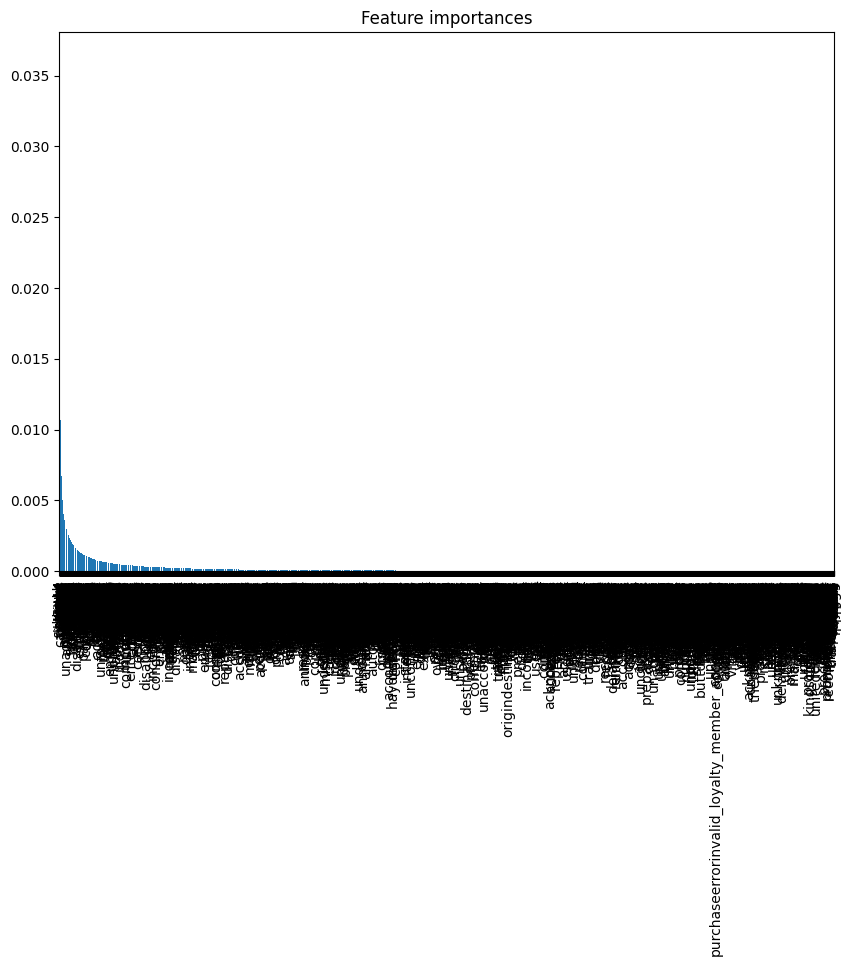

In [83]:
#Use the feature importance from the Random Forest model to understand which features are contributing the most to the predictions.
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):  # Show top 10 features
    print(f"{f + 1}. Feature {tfidf_vectorizer.get_feature_names_out()[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances of the forest
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_train_tfidf.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_tfidf.shape[1]), tfidf_vectorizer.get_feature_names_out()[indices], rotation=90)
plt.xlim([-1, X_train_tfidf.shape[1]])
plt.show()


In [84]:
#Check the DataFrame Structure
# Check the first few rows and the column names of the DataFrame
print(tweets_df.head())  # Display the first few rows
print(tweets_df.columns)  # Display the column names


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

<Figure size 1200x700 with 0 Axes>

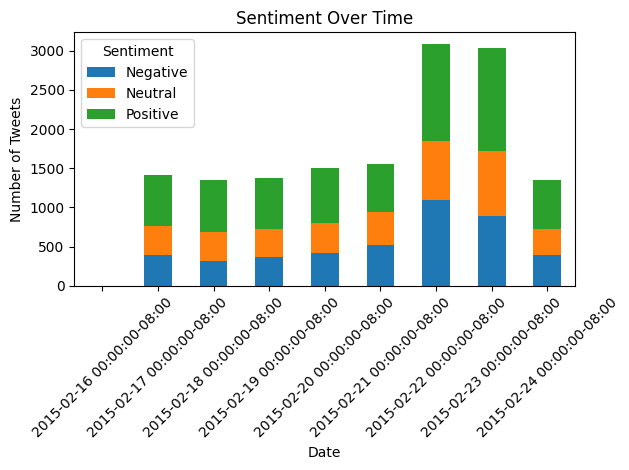

In [85]:
# Sentiment Time Series Analysis
# Continue with the updated analysis
# Convert 'tweet_created' to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['tweet_created'])  # Ensure to use 'tweet_created'
tweets_df.set_index('date', inplace=True)

# Resample the data by day and count the occurrences of each sentiment
sentiment_over_time = tweets_df.resample('D')['sentiment'].value_counts().unstack().fillna(0)

# Plotting sentiment over time
plt.figure(figsize=(12, 7))
sentiment_over_time.plot(kind='bar', stacked=True)
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.tight_layout()  # Adjust layout to fit
plt.show()


In [86]:
# Ensure lengths match for verifying dimensions before plotting
print(f'y_test shape: {y_test.shape}')
print(f'y_pred_proba_lr shape: {y_pred_proba_lr.shape}')
print(f'y_pred_proba_svm shape: {y_pred_proba_svm.shape}')
print(f'y_pred_proba_rf shape: {y_pred_proba_rf.shape}')
print(f'y_test_lstm shape: {y_test_lstm.shape}')
print(f'y_pred_proba_lstm shape: {y_pred_proba_lstm.shape}')
print(f'y_pred_classes_lstm shape: {y_pred_classes_lstm.shape}')



y_test shape: (3660,)
y_pred_proba_lr shape: (3660,)
y_pred_proba_svm shape: (3660,)
y_pred_proba_rf shape: (3660,)
y_test_lstm shape: (3660,)
y_pred_proba_lstm shape: (3660,)
y_pred_classes_lstm shape: (3660,)
